<i><b>Public AI</b></i>
<br>
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 1. DNN Basis**
# Section 10. Keras를 활용한 딥러닝 모델 만들기


### _Objective_
1. **Fashion MNIST** : Keras를 활용하여 간단한 MLP(Multi layer Perceptron) 모델을 구성해 보도록 하겠습니다.

In [1]:
%matplotlib inline

import os
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# \[ Fashion MNIST \]

손글씨로 숫자(0, 1, 2 등)를 쓴 이미지로 이루어진 MNIST 데이터셋은 컴퓨터 비전 분야에서 "Hello, World" 프로그램 격인, 고전적으로 사용되어온 샘플 데이터셋입니다. MNIST 데이터셋은 비교적 작기 때문에 알고리즘의 작동 여부를 확인하기 위해 사용되곤 합니다. 코드를 테스트하고 디버깅하는 용도로 좋습니다. 이번 Section에서는 고전 MNIST 데이터셋보다 조금 더 어려운 데이터셋이면서, 다양한 예제를 만들어 활용할 수 있는 패션 MNIST 데이터셋을 사용해보려고 합니다.

패션 MNIST 데이터셋은 10개의 범주(class)와 70,000개의 흑백 이미지로 구성되어 있습니다. 각 이미지는 옷이나 패션 소품 이미지이며, 해상도(28x28 픽셀)가 낮습니다.

![](https://i.imgur.com/Q71P1Vr.png)

네트워크를 훈련하는데 60,000개의 이미지를 사용하고, 훈련된 네트워크가 이미지를 잘 분류하는지 분류하는지 10,000개의 이미지로 평가하겠습니다. 패션 MNIST 데이터셋은 텐서플로에서 바로 임포트하여 가져올 수 있습니다.

## 1. 데이터 가져오기

`keras.datasets.fashion_mnist`를 불러와 `load_data()` 함수를 호출하면 `train_images, train_labels, test_images, test_labels` 네 개의 NumPy 배열이 반환됩니다:

In [2]:
# fashion mnist 가져오기
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images와 train_labels 배열은 모델 학습에 사용되는 훈련용 데이터셋이며, test_images와 test_labels 배열은 모델 성능 테스트에 사용되는 테스트 데이터 셋입니다. 

각 이미지의 크기는 28x28 이기 때문에, `train_image`에서 한 값만 가져와 크기를 살펴 보면 아래와 같은 형태를 가지는 것을 알 수 있습니다.

In [3]:
train_images[0].shape

(28, 28)

픽셀 값은 0과 255 사이입니다. 

In [4]:
train_images.min(), train_images.max()

(0, 255)

레이블(label), 즉 각 이미지가 무엇인지 나타내는 정답은 10가지로, 0에서 9까지의 정수 배열로 표현됩니다. 

In [5]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

각 값은 아래의 클래스를 의미합니다.

| 레이블 | 클래스 |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

각 이미지는 하나의 레이블에 매핑되어 있습니다. 데이터셋에 클래스 이름 문자열로 들어있지 않기 때문에, 나중에 이미지를 출력할 때 참고하기 위해 별도의 변수를 만들어 저장합니다:

In [6]:
# class name 지정해주기
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 2. 데이터 파악하기

정리하면, 앞서 가져온 `train_images`는 아래와 같이 구성되어 있습니다.

In [7]:
print("훈련 set의 shape : ", train_images.shape)
print("훈련 set의 label : ", set(train_labels))
print("테스트 set의 shape : ", test_images.shape)

훈련 set의 shape :  (60000, 28, 28)
훈련 set의 label :  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
테스트 set의 shape :  (10000, 28, 28)


이렇게 숫자로만 이루어진 배열이 정말 이미지로 표현이 될까요? 각 이미지의 레이블은 정확한 걸까요? 60000개 중 50개만 직접 확인해봅시다.

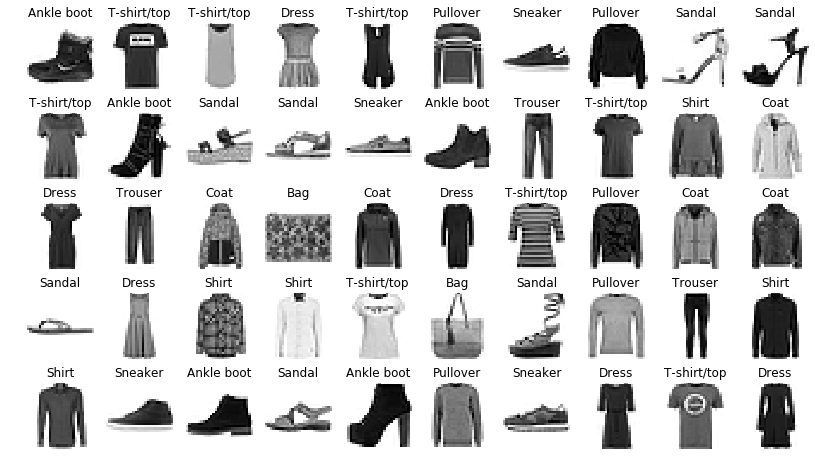

In [8]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(train_images[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[train_labels[index]])
plt.show()

해상도는 떨어지긴 하지만, 적절한 데이터를 가져왔고, 레이블 역시 잘 되어있는 것 같습니다. 그럼 이제 본격적으로 분류모델을 만들어봅시다.

## 3. 데이터 전처리하기
네트워크를 훈련하기 전에 데이터를 전처리해야 합니다. 먼저 첫 번째 이미지를 보고, 어떤 전처리가 필요한지 살펴봅시다.

### (1) 데이터 정규화하기

훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~255 사이라는 것을 알 수 있습니다. 

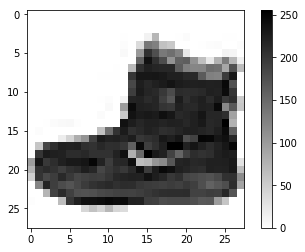

In [9]:
plt.figure()
plt.imshow(train_images[0], cmap='binary')
plt.colorbar()
plt.show()

train image와 test image의 값을 0 에서 1 사이로 조정하기 위해 255로 나누어 줍니다.

In [10]:
train_images = train_images / 255.0
test_images = test_images / 255.0

### (2) One-hot 인코딩하기

데이터가 숫자로 표현되었다고 해서 항상 그 숫자 그대로 의미를 가지는 것은 아닙니다. 예를 들어 Fashion MNIST의 레이블은 "Coat", "Dress", "Shirt"와 같이 문자형으로 되어있으며, 이를 0부터 9까지의 숫자로 표현합니다. 하지만, 1번 클래스 Trouser가 9번 클래스 Ankle boot보다 9배 작다거나 하는 숫자적 의미를 가지진 않는다는 것이죠. 이런 데이터를 "범주형 데이터(categorical data)"라고 부릅니다. 이 숫자를 그대로 모델에 넣어 학습시키게 되면, 모델은 의미 없는 레이블 숫자가 의미가 있다고 판단하고 트레이닝을 하게 될 것입니다. 따라서 숫자로 표현했지만, 사실은 문자인 이 데이터가 범주형 데이터임을 기계가 인식할 수 있도록 바꿔주어야 합니다. 그 방법론 중 하나가 **One-hot Encoding**입니다. One-hot encoding의 과정은 다음과 같습니다.

**One-hot Encoding**
1. 각 단어에 고유한 인덱스를 부여합니다.
2. 표현하고 싶은 단어의 인덱스 위치에 1을 부여하고, 다른 단어의 인덱스 위치에는 0을 부여합니다.

| 레이블 | 클래스 |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

예를 들어, 레이블 `4`의 `Coat` 클래스를 [0,0,0,0,1,0,0,0,0,0]과 같이 표현하는 것입니다. 이 과정을 keras에서는 아래와 같이 쉽게 구현할 수 있습니다.

In [11]:
from tensorflow.keras.utils import to_categorical
train_labels_first_10 = train_labels[:10]
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

첫 10개 이미지의 레이블은 아래와 같았습니다.

In [12]:
train_labels_first_10

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

위와 같았던 레이블이 원한인코딩을 하면 아래와 같이 변환됩니다.

In [13]:
train_labels[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

## 4. 딥러닝 모델 구성하기

이제 기본적인 데이터 전처리는 끝났습니다. 이제 딥러닝 모델을 구성해봅시다.

### (1) 입력층 구성하기

먼저, 입력층을 구성해야 합니다. 입력층에서 각 이미지의 크기는 `28 * 28`이므로 일단 `shape=(28, 28)`로 설정합니다.

In [14]:
from tensorflow.keras.layers import Input

# fix me! # input shape이 (28,28)인 Input layer를 구성해주세요

<tf.Tensor 'images:0' shape=(None, 28, 28) dtype=float32>

원본 데이터에서 각 이미지는 `28 * 28` 형태의 행렬로 표현되지만, 모델을 학습시키기 위해서는 각 이미지 행렬을 하나의 벡터로 변환해야 합니다. `Reshape` 혹은 `Flatten`을 사용합니다.

In [15]:
# 방법1. layers의 Reshape 이용하기
from tensorflow.keras.layers import Reshape

# fix me! # Reshape Layer를 추가해 input을 행렬이 아닌 하나의 벡터로 변환해주세요

<tf.Tensor 'reshape/Identity:0' shape=(None, 784) dtype=float32>

In [16]:
# 방법2. layers의 Flatten 이용하기
from tensorflow.keras.layers import Flatten

# fix me! # Flatten Layer를 추가해 input을 행렬이 아닌 하나의 벡터로 변환해주세요

<tf.Tensor 'flatten/Identity:0' shape=(None, 784) dtype=float32>

### (2) 은닉층 구성하기

이제 입력층이 완성되었으니 은닉층을 구성해봅시다. 은닉층은 2개로 구성해보겠습니다. 첫번째 은닉층 `dense1`은 입력층에서 넘어온 `reshape` 데이터를 받으며, 128개의 유닛으로 구성됩니다. 활성화 함수로는 렐루 함수를 쓰겠습니다. 두번째 은닉층 `dense2`에서는 첫번째 은닉층에서 넘어온 `dense1` 데이터를 받으며, 마찬가지로 유닛은 128개, 활성화 함수는 렐루 함수를 쓰겠습니다.

In [17]:
from tensorflow.keras.layers import Dense

# fix me! # Dense Layer를 추가해 조건에 맞는 2개의 은닉층을 만들어보세요

### (3) 출력층 구성하기

끝으로 출력층을 구성해보겠습니다. 출력층은 유닛 10개로 구성하고 활성화 함수로는 `softmax`를 설정하겠습니다. 

In [18]:
# fix me! # Dense Layer를 추가해 조건에 맞는 출력층을 만들어보세요. 

왜 softmax를 마지막 출력층의 활성화 함수로 설정했을까요? 모델로부터 반환받고 싶은 값이 "이미지가 각 클래스일 확률"이기 때문입니다. 

<img src="https://imgur.com/Ln1CHHW.png" width="800" height="600"/>

### (4) 모델 구성하기

이제 앞서 만든 레이어를 합쳐 모델을 만들겠습니다. `Param #`에 값이 있는 층은 총 3개(은닉층 2개와 출력층 1개)이므로 3층 신경망 모델입니다.

In [19]:
from tensorflow.keras.models import Model

# fix me! # Model을 구성하고 Model.summary를 사용해 Model의 구조를 살펴보세요

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


## 5. 모델 학습시키기

### (1) 옵티마이저 결정하기

이제 이렇게 만든 모델로 여러번 예측값을 내보면서 오차를 줄이는 방향으로 훈련을 시켜나갈 것입니다. 옵티마이저로는 `SGD, RMSprop, Adam` 등을 쓸 수 있는데, 이번에는 `Adam`을 사용하겠습니다.

In [20]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

In [21]:
# fix me! # SGD 최적화 함수를 만들어보세요 (lr=0.01)
# fix me! # RMSprop 최적화 함수를 만들어보세요 (lr=0.01, rho=0.9)
# fix me! # Adam 최적화 함수를 만들어보세요 (lr=1e-3, beta_1=0.9, beta_2=0.999)

### (2) 손실함수 결정하기

손실함수로는 `cross-entropy`를 사용하겠습니다.

> 로짓값 범위 확인하고 이미지 구성하기


<img src="https://i.imgur.com/ilP3eZf.png" width="800" height="600"/>

In [22]:
from tensorflow.keras.losses import CategoricalCrossentropy

In [23]:
# fix me! # Categorical CrossEntropy loss 함수를 만들어보세요

### (3) 모델 컴파일하기

이제 이렇게 만들어진 모델을 컴파일해보겠습니다. 앞서 설정한 옵티마이저 `optim`과 손실함수 `loss_func`을 파라미터로 넣습니다. 끝으로 가장 확률이 높은 2개의 클래스만 반환하라는 의미에서 `metric` `TopKCategoricalAccuracy(k=2)`로 설정합니다.

In [24]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy

In [25]:
# fix me! # k=2 TopK categorical accuracy를 metric으로 사용해주세요

In [26]:
# fix me! # 위에서 결정한 optimizer, loss function, metric을 사용해 모델을 컴파일해보세요

### (4) 모델 학습시키기

모델이 컴파일 되었으니, `fit()` 메소드를 이용해 학습을 시작합니다. 

In [27]:
# fix me! # fit()메소드를 이용해 학습을 진행해보세요
# (batch_size=64, validation_split=0.1, epochs=10)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 3s 62us/sample - loss: 0.5105 - top_k_categorical_accuracy: 0.9374 - val_loss: 0.4186 - val_top_k_categorical_accuracy: 0.9528
Epoch 2/10
54000/54000 [==============================] - 2s 42us/sample - loss: 0.3727 - top_k_categorical_accuracy: 0.9616 - val_loss: 0.3906 - val_top_k_categorical_accuracy: 0.9653
Epoch 3/10
54000/54000 [==============================] - 2s 40us/sample - loss: 0.3315 - top_k_categorical_accuracy: 0.9671 - val_loss: 0.3447 - val_top_k_categorical_accuracy: 0.9670
Epoch 4/10
54000/54000 [==============================] - 2s 46us/sample - loss: 0.3078 - top_k_categorical_accuracy: 0.9710 - val_loss: 0.3403 - val_top_k_categorical_accuracy: 0.9677
Epoch 5/10
54000/54000 [==============================] - 2s 45us/sample - loss: 0.2920 - top_k_categorical_accuracy: 0.9729 - val_loss: 0.3586 - val_top_k_categorical_accuracy: 0.9605
Epoch 6/10
54000/54000 [==

### (5) 모델 평가하기

훈련이 끝난 모델에 테스트용으로 분리해놓은 테스트용 이미지와 레이블을 넣어 정확도를 평가합니다. 모델의 정확도가 94.07%로 평가되었습니다.

In [28]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)

print('테스트 정확도:', test_acc)

테스트 정확도: 0.9648


#  

<hr>
<div>
    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, DoYeong Kim ( ka2k@publicai.co.kr )  last updated on 2019/10/07
</div>
<hr>